# WALDO RIVIER 07.12.2018 
Applied Data Science : Machine Learning
---
Exercices module 3 Predicting houses prices
---


In [75]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from scipy.linalg import lstsq
from scipy import stats

from sklearn.metrics import r2_score
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

import itertools
import math
import random

Class which implements utilities to access house price meta data 
--
- columns, column's type, etc...
- transformation of ordinal column code mapping, tansfomation of entire ordinal columns of a dataframe, etc...
- meta data are stored in a text file

In [76]:
class meta_data:
    _working_dir = None
    _df_meta = None

    def __init__(self, working_dir):
        self._working_dir = working_dir
        self._load_meta_data()

    def _load_meta_data(self):
        data_file = os.path.join(self._working_dir, 'meta_data.txt')

        self._df_meta = pd.DataFrame.from_csv(data_file, sep='\t')
        self._df_meta.reset_index(inplace=True)
        self._df_meta.ffill(inplace=True)

    def _get_type_of_col(self, col):
        try:
            return self._df_meta[self._df_meta['column'] == col]['type'].iloc[0]
        except:
            print ("Column not found in meta data " + col)
    
    def get_cols_of_type(self, type):
        cols = self._df_meta.copy()
        cols = cols[cols.type==type]['column'].drop_duplicates()
        return cols

    def get_dict_ordinal(self, col):
        dict_ordinal = None
        if self._get_type_of_col(col) == 'Ordinal':
            df_ordinal = self._df_meta[self._df_meta['column'] == col]
            codes = df_ordinal.code.values
            try:
                codes = codes.astype(float)
            except:
                codes = [i.strip() for i in df_ordinal.code.values]
         
            dict_ordinal = dict(zip(codes, df_ordinal.ordinal_value.values))
        return dict_ordinal

    #------------------------------------------------------------------------------
    # return dictionary build on code and code designation (used in special case
    # for MS SubClass feature) 
    #------------------------------------------------------------------------------
    def get_dict_nominal(self, col):
        dict_nominal = None
        if self._get_type_of_col(col) == 'Nominal':
            df_nominal = self._df_meta[self._df_meta['column'] == col]
            codes = df_nominal.code.values
            try:
                codes = codes.astype(int)
            except:
                codes = [i.strip() for i in df_nominal.code.values]
         
            dict_nominal = dict(zip(codes, df_nominal.code_designation.values))
        return dict_nominal

    def _map_col(self, df, col, type):
        if df.columns.contains(col):
            if self._get_type_of_col(col) == type:
                dict_ordinal = self.get_dict_ordinal(col)
                df[col] = df[col].map(dict_ordinal)
    
    def _map_ordinal_col(self, df, col):
       self._map_col(df, col, 'Ordinal')
       
    # all ordinal columns's code will be associated with numerical values as defined in meta data
    def map_ordinal_cols(self, df):
        cols = self.get_cols_of_type('Ordinal')
        for col in cols:
            self._map_ordinal_col(df, col)

Class which implements utilities to manage house price data
--
- encapsulate train data set
- encapsulate data set to predict

In [77]:
class sample_data:
    _meta_data = None
    _working_dir = None
    _target = None
 
    _df_test_data = None
    _df_train_data = None
    _df_train_data_orig = None
 
    def __init__(self, working_dir, target, meta_data):
        assert working_dir is not None and len(working_dir) > 0
        assert target is not None and len(target) > 0
        assert meta_data is not None
        
        self._working_dir = working_dir
        self._meta_data = meta_data
        self._target = target

    def load_data(self):
        self._load_train_data()
        self._load_test_data()
        
        
    def _load_train_data(self):
        data_file = os.path.join(self._working_dir, 'house-prices.csv')
 
        # save a copy of original train data     
        self._df_train_data_orig = pd.read_csv(data_file)
 
    #------------------------------------------------------------------------------ 
    # load the data set to predict Saleprice
    #------------------------------------------------------------------------------ 
    def _load_test_data(self):
        data_file = os.path.join(self._working_dir, 'house-prices-test.csv')
        self._df_test_data = pd.read_csv(data_file)
        
    #------------------------------------------------------------------------------    
    # Prepare data for the training phase
    #------------------------------------------------------------------------------
    def prepare_train_data(self):
        assert self._df_train_data_orig is not None 

        # drop all columns which contains more than one NAN value
        # motivations :
        #   a. number of features removed is not dramatically important (20 on 81)
        #   b. 7 features contains only 1 NAN value; without big effort and modification of 
        #        the informations, we can  easyly keep them

        self._df_train_data = self._df_train_data_orig.dropna(thresh=2429, axis=1).copy()
        self._df_train_data.fillna(method='ffill', inplace=True)

        # takes the log the target
        self._df_train_data[self._target] = np.log(self._df_train_data[self._target])

        # all ordinal features will be replaced with numerical (subjective) evaluations
        self._meta_data.map_ordinal_cols(self._df_train_data)

        # special case for features MS SubClass; apply transformation in order 
        # to use nominal text in place of numerical codes
        col = 'MS SubClass'
        dict_nominal = self._meta_data.get_dict_nominal(col)
        self._df_train_data[col] = self._df_train_data[col].map(dict_nominal)

        # apply some transformation to "normalize" the distribution
        self.apply_transformation('Fireplaces')
        self.apply_transformation('Year Built')
        
    #------------------------------------------------------------------------------
    # return the prediction data; ordinal columns will be mapped
    #------------------------------------------------------------------------------       
    def prepare_prediction_data(self):
        assert self._df_test_data is not None

        self._meta_data.map_ordinal_cols(self._df_test_data) 
    
    #------------------------------------------------------------------------------
    # return the features which were removed in function prepare_train_data above
    #------------------------------------------------------------------------------
    def get_removed_cols(self): 
        return self._df_train_data_orig.columns.difference(set(self._df_train_data.columns))
        
    def get_cols_of_type(self, df, type):
        cols = df.columns.intersection(self._meta_data.get_cols_of_type(type))
        return cols
 
    def get_cols_wo_target(self):
        assert self._df_train_data is not None

        cols = self._df_train_data.columns.copy()
        cols = cols.drop(self._target)
        cols = cols.drop(['Order', 'PID'])
        return cols

    #------------------------------------------------------------------------------
    # iterate over all features (eventually encoded) and plot SalePrice as response
    #------------------------------------------------------------------------------
    def iterate_pair_plot(self):
        col_cnt = len(self.get_cols_wo_target())

        for i in np.arange(0, col_cnt):
            self._pair_plot(i)
   
    def pair_plot(self, col):
        assert self._df_train_data.columns.contains(col)

        df = self._df_train_data.copy()
        df = df[[self._target, col]]
       
        if self._meta_data._get_type_of_col(col) == 'Nominal':
            df = pd.get_dummies(df, col)    

        cols = df.columns.drop(self._target)
        g = sns.pairplot(df, x_vars=cols,
            y_vars=[self._target], 
            kind="reg",
            plot_kws={'line_kws':{'color':'red'}})
        plt.show()

    #------------------------------------------------------------------------------
    # plot histogram of a features (eventually encoded) 
    #------------------------------------------------------------------------------
    def hist_plot(self, col):
        assert self._df_train_data.columns.contains(col)

        df = self._df_train_data.copy()
        df = df[col]
      
        if self._meta_data._get_type_of_col(col) == 'Nominal':
            df = pd.get_dummies(df, col)    

        df.hist()
        plt.show()
        
    #------------------------------------------------------------------------------
    # return the Saleprice distribution of train data set
    #------------------------------------------------------------------------------
    def get_train_distribution(self):
        assert self._df_train_data is not None

        return np.exp(self._df_train_data.SalePrice).describe()
    
    #------------------------------------------------------------------------------
    # apply some transformations on some features
    #------------------------------------------------------------------------------
    def _indicator(self, col):
        def _f_fire_places(x):
            if x >= 1:
                return 1
            else:
                return 0
            return _f

        def _f_year_built(x):
            if x > 1970:
                return 'after_1970'
            else:
                return 'before_1970'

        if col == 'Fireplaces':
            return _f_fire_places
        elif col == 'Year Built':
            return _f_year_built
        
        
    def apply_transformation(self, col):
        assert self._df_train_data.columns.contains(col)

        indicator = self._indicator(col)
        assert indicator is not None
        self._df_train_data[col] = self._df_train_data[col].apply(indicator)

    #------------------------------------------------------------------------------
    # inner class used to store result of runs
    #------------------------------------------------------------------------------
    class result:
        _metric = None
        comb_cols = None
        cols = None
        lr = None
        train_score = None
        test_score = None
        test_baseline  = None
        PID_pred = None
        y_te = None
        y_te_pred = None

        def __init__(self, metric):
            self._metric = metric

        def as_dict(self):
            return {'metric' : self._metric,
                    'PID_test' : self.PID_pred,
                    'comb_cols' : self.comb_cols,
                    'cols' : self.cols,
                    'lr' : self.lr,
                    'train_score' : self.train_score,
                    'test_score' : self.test_score,
                    'test_baseline' : self.test_baseline,
                    'y_te' : self.y_te,
                    'y_te_pred' : self.y_te_pred}

return number of arrangments of k objects taken among n objects

In [78]:
def anp(n, k):
    return math.factorial(n) / (math.factorial(k) * math.factorial(n - k))

Evaluates a model 
--

- reg_type : type of regression to apply (linear, huber, ridge)
- alpha : parameter for ridge regression
- metric : metric to apply (median, mean)
- sample_data : train data
- comb_cols : sublist of features taken among train data 
- results : list of results into which the result of the run will be added

In [79]:
def run_train(reg_type, alpha, metric, sample_data, comb_cols, results):
    try:
        df = sample_data._df_train_data.copy()
        y = df[sample_data._target]
        df = df[comb_cols]
        
        cols = sample_data.get_cols_of_type(df, 'Nominal')
        if len(cols) > 0:
            df = pd.get_dummies(df, columns=cols)

        _X = df.values
        X_tr, X_te, y_tr, y_te = train_test_split(
           _X, y.values, train_size = 0.5, test_size = 0.5, random_state=1)

        if reg_type == 'linear':
            reg = LinearRegression()
        elif reg_type == 'huber':
            reg = HuberRegressor(1.35)
            y_tr = y_tr.flatten()
        elif reg_type == 'ridge':    
            if alpha is not None: 
                reg = Ridge(alpha)

        reg.fit(X_tr, y_tr)
        y_pred_tr = reg.predict(X_tr)
        y_pred_te = reg.predict(X_te)
   
        # stores the results
        r = sample_data.result(metric)

        # evaluate the metric
        dummy = DummyRegressor(strategy=metric)
        dummy.fit(X_tr, y_tr)
        y_pred_base = dummy.predict(X_te)   

        if metric == 'mean':
            r.train_score = np.sqrt(mse(y_pred_tr, y_tr))
            r.test_score = np.sqrt(mse(y_pred_te, y_te))
            r.test_baseline = np.sqrt(mse(y_pred_base, y_te))
        elif metric == 'median':
            r.train_score = mae(y_pred_tr, y_tr)
            r.test_score = mae(y_pred_te, y_te)
            r.test_baseline = mae(y_pred_base, y_te)
           
        r.comb_cols = comb_cols
        r.cols = df.columns
        r.lr = reg
        r.PID_test = None
        r.y_te = y_te
        r.y_te_pred = y_pred_te
        results.append(r)
        
    except:
        print(comb_cols)

Build prediction
--

- optimal train : best result of a list of runs
- sample_data : data which contains the test data set to predict


In [80]:
def build_prediction(optimal_train, sample_data):
    assert sample_data is not None
    assert optimal_train is not None

    try:
        id = 'PID'
        df = sample_data._df_test_data.copy()
        PID = df[id]

        df = df[optimal_train.comb_cols]
        
        cols = sample_data.get_cols_of_type(df, 'Nominal')
        if len(cols) > 0:
            df = pd.get_dummies(df, columns=cols)

        # re-index test set in order to be compatible with train set 
        df = df.reindex(columns=optimal_train.cols)
        df.fillna(0, inplace=True)

        X = df.values
        y_pred_te = optimal_train.lr.predict(X)
  
        prediction = sample_data.result(optimal_train.metric)
        prediction.PID_test = PID
        prediction.comb_cols = optimal_train.comb_cols
        prediction.cols = df.columns

        # transform 
        prediction.y_te_pred = np.exp(y_pred_te)

        # format to a 2-column DataFrame
        df = pd.concat([pd.DataFrame(prediction.PID_test), 
                        pd.DataFrame(prediction.y_te_pred)], axis=1)
        df.columns = ['PID', 'SalePrice']
        return df
        
    except:
        print(optimal_train.comb_cols)

Class which implements functionalities to test and select an otptimal model
--

In [81]:
class model_selector:
    _prediction_base_file_name = 'house-prices-pred'
    _sample_data = None
    _train_results = None
    _prediction = None

    def __init__(self, sample_data):
        assert sample_data is not None

        self._sample_data = sample_data
 
    def reset_run(self):
        self._train_results = None
        self._prediction = None

    #--------------------------------------------------------------------------
    # enumerates all possible combinations with k features
    # perform and write perdictions
    # limit : max combinations 
    # reg_type : linear, huber, ridge
    #--------------------------------------------------------------------------
    def run_combinations(self, reg_type, alpha, metric, k, limit):
        self._sample_data.prepare_train_data()

        cols = self._sample_data.get_cols_wo_target()
        cols_cnt = len(cols)

        if (cols_cnt >= k):
            # avoid too many combinations to be evaluated
            if (anp(cols_cnt, k) < 2000):
                combinations = [list(x) for x in itertools.combinations(cols, k)]
                combinations = [random.choice(combinations) for i in np.arange(limit)]

                self._train_results = []
                for combination in combinations:
                    run_train(reg_type, alpha, metric, sample_data, combination, self._train_results)

                self._sample_data.prepare_prediction_data()
                self._prediction = build_prediction(self._find_optimal_train(), self._sample_data)
  
    #--------------------------------------------------------------------------
    # add features to an (eventually already evaluated) optimal combination 
    # in order to build a more accurate model.
    # a new optimal train will be evaluated
    #--------------------------------------------------------------------------
    def run_combination(self, reg_type, alpha, metric, cols):
        self._sample_data.prepare_train_data()

        # when no optimal train already exists, 
        try :
            opt_train = self._find_optimal_train()
            combination = opt_train.comb_cols.copy()
        except:
            combination = []
        combination.extend(cols)

        self._train_results = []
        run_train(reg_type, alpha, metric, sample_data, combination, self._train_results)

        sample_data.prepare_prediction_data()
        self._prediction = build_prediction(self._find_optimal_train(), sample_data)
   
    #--------------------------------------------------------------------------
    # run grid seach ridge regression with given features 
    #--------------------------------------------------------------------------
    def run_ridge_grid(self, metric, cols):
        self._sample_data.prepare_train_data()
        
        self._train_results = []
        for alpha in np.logspace(-2, 10, num=100):
            run_train('ridge', alpha, metric, sample_data, cols, self._train_results)
        
        # plot ridge grid results
        if self._train_results is not None:
            df = pd.DataFrame([x.as_dict() for x in self._train_results])
            alphas = [x.alpha for x in df.lr]

            plt.semilogx(alphas, df.train_score, label='mse train curve')
            plt.semilogx(alphas, df.test_score, label='mse test curve')
            plt.legend()
            plt.show()

            sample_data.prepare_prediction_data()
            self._prediction = build_prediction(self._find_optimal_train(), sample_data)

    #--------------------------------------------------------------------------
    # find an optimal test score among all train's run
    #--------------------------------------------------------------------------
    def _find_optimal_train(self):
        assert self._train_results is not None

        df = pd.DataFrame([x.as_dict() for x in self._train_results])
        i_opt = df['test_score'].idxmin()
        return df.iloc[i_opt,:]

    #--------------------------------------------------------------------------
    # get Saleprice distibution of the optimal train 
    #--------------------------------------------------------------------------
    def get_prediction_distribution(self):
        assert self._prediction is not None

        return self._prediction.SalePrice.describe()

    #--------------------------------------------------------------------------
    # write prediction data to a csv file
    #--------------------------------------------------------------------------
    def _write_prediction(self, suffix):
        assert self._prediction is not None
   
        if suffix is not None:
            file_name = self._prediction_base_file_name  + str('-') + (suffix)
        file_name += str('.csv')

        data_file = os.path.join(self._sample_data._working_dir, file_name)
        self._prediction.to_csv(data_file, index=False)
  
    #--------------------------------------------------------------------------
    # plot optimal train
    #--------------------------------------------------------------------------
    def _plot_optimal_train(self):
        opt = self._find_optimal_train()

        values = [opt.test_baseline,  
                  opt.train_score,
                  opt.test_score, ]
  
        fig, ax = plt.subplots()

        bar_width = 0.6
        index = np.arange(len(values))
        rects1 = ax.bar(index, values, bar_width, color='g')
        ax.set_xlabel('metrics')
        ax.set_ylabel('mse score')
        ax.set_title(opt.comb_cols)
        ax.set_xticks(index)

        ax.set_xticklabels(('baseline test score', 'train score', 'test score'))
        plt.show()

Models evaluations
--

In [82]:
working_dir = os.getcwd()
working_dir = os.path.join(working_dir, 'data', 'module_3')

meta_data = meta_data(working_dir)
sample_data = sample_data(working_dir, 'SalePrice', meta_data)
sample_data.load_data()

# dictionnary to store the optimal result of each model
model_optimal_train_results = {}


c:\users\waldo\source\repos\study_1\courses\courses\env\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  if sys.path[0] == '':


A. Simple model with only two features
---

In [83]:
model_selector = model_selector(sample_data)

In [84]:
model_selector.run_combinations('linear', None, 'mean', 2, 2000)

In [85]:
model_selector._find_optimal_train()

PID_test                                                      None
cols             Index(['Overall Qual', 'Gr Liv Area'], dtype='...
comb_cols                              [Overall Qual, Gr Liv Area]
lr               LinearRegression(copy_X=True, fit_intercept=Tr...
metric                                                        mean
test_baseline                                             0.398547
test_score                                                0.196574
train_score                                                0.20813
y_te             [11.507912923146684, 11.964001084330445, 12.20...
y_te_pred        [11.871774172869303, 11.798193400300399, 12.04...
Name: 730, dtype: object

couple of features which gives the best score

In [86]:
model_selector._find_optimal_train().cols

Index(['Overall Qual', 'Gr Liv Area'], dtype='object')

In [87]:
model_selector.get_prediction_distribution()

count       500.000000
mean     181095.023514
std       73813.141229
min       60877.698849
25%      127549.265064
50%      160464.718681
75%      215319.877195
max      733605.836891
Name: SalePrice, dtype: float64

compare distribution above with train data set ones

In [88]:
sample_data.get_train_distribution()

count      2430.000000
mean     180199.692593
std       79607.467171
min       12789.000000
25%      129000.000000
50%      160000.000000
75%      213099.750000
max      755000.000000
Name: SalePrice, dtype: float64

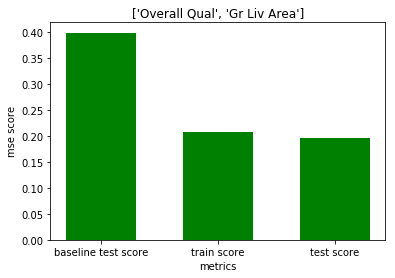

In [89]:
model_selector._plot_optimal_train()

write prediction to file

In [90]:
 model_selector._write_prediction('simple')

In [91]:
model_optimal_train_results['simple'] = model_selector._find_optimal_train()

B. Intermediate model 
--

This model is built with the 2 features determined above and 8 added features;  features are choosen according following criterias :
- a. individual correlation with the target
- b. distribution as near as normal distribution

In [92]:
optimal_cols =  ['Overall Qual', 'Gr Liv Area']
cols_to_add = ['Fireplaces', 'Lot Area', 
               'TotRms AbvGrd', 'Year Built',
               '1st Flr SF', 'MS SubClass', 
               'Central Air', 'Garage Cars']


In [93]:
model_selector.reset_run()
model_selector.run_combination('linear', None, 'mean', optimal_cols)
model_selector._find_optimal_train()
model_selector.get_prediction_distribution()

count       500.000000
mean     181095.023514
std       73813.141229
min       60877.698849
25%      127549.265064
50%      160464.718681
75%      215319.877195
max      733605.836891
Name: SalePrice, dtype: float64

adds columns one after the other to be sure that the prediction 
distribution conserves a good fit in comparison to the train'one 

count       500.000000
mean     179880.140042
std       71314.247249
min       61896.123457
25%      127202.799191
50%      165542.730036
75%      212263.710479
max      674690.829608
Name: SalePrice, dtype: float64


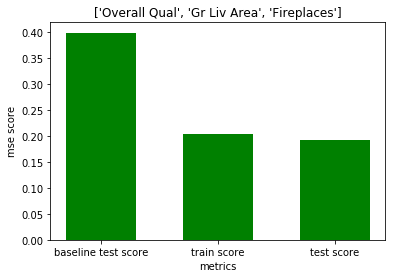

count       500.000000
mean     179082.267527
std       71914.594175
min       62125.904703
25%      127227.693820
50%      163911.668099
75%      211910.178664
max      716973.481572
Name: SalePrice, dtype: float64


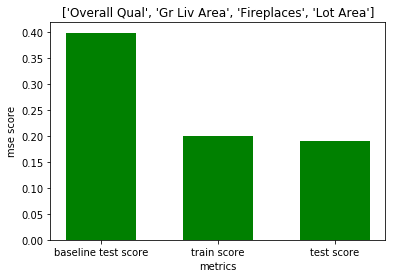

count       500.000000
mean     179030.075041
std       72106.358392
min       62216.657208
25%      127181.265672
50%      163603.764415
75%      211556.480102
max      729396.732193
Name: SalePrice, dtype: float64


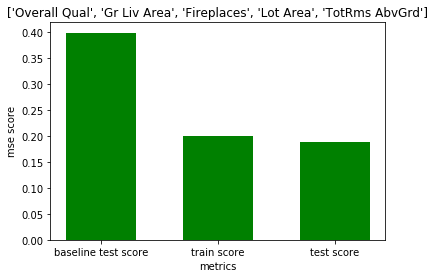

count       500.000000
mean     176661.516913
std       65572.070035
min       67543.034105
25%      129786.092073
50%      163423.840164
75%      207165.813270
max      680575.214043
Name: SalePrice, dtype: float64


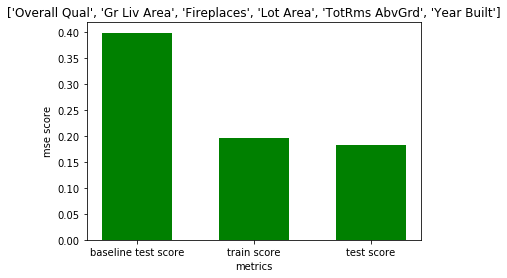

count       500.000000
mean     176068.078018
std       65152.096090
min       67530.739810
25%      130527.290402
50%      159514.515624
75%      205454.172592
max      706058.011935
Name: SalePrice, dtype: float64


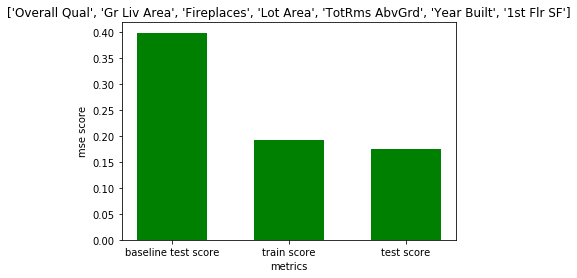

count       500.000000
mean     167738.131154
std       62154.844906
min       64949.065274
25%      123573.121484
50%      154340.641237
75%      194208.787262
max      665106.686539
Name: SalePrice, dtype: float64


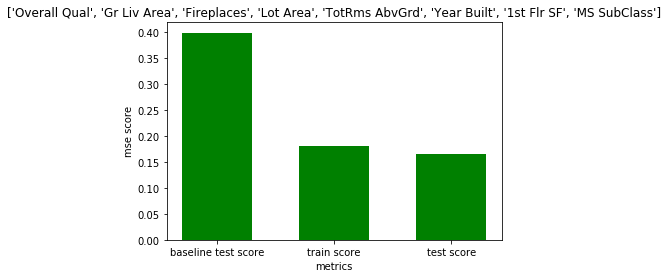

count       500.000000
mean     169601.785282
std       61443.182469
min       67116.383779
25%      126379.493310
50%      158101.478617
75%      196589.508528
max      653855.849931
Name: SalePrice, dtype: float64


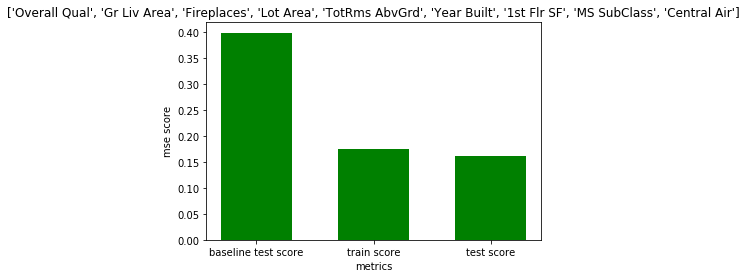

count       500.000000
mean     171995.800474
std       65195.477904
min       63172.795402
25%      125122.979956
50%      159533.406317
75%      200534.776122
max      639927.747199
Name: SalePrice, dtype: float64


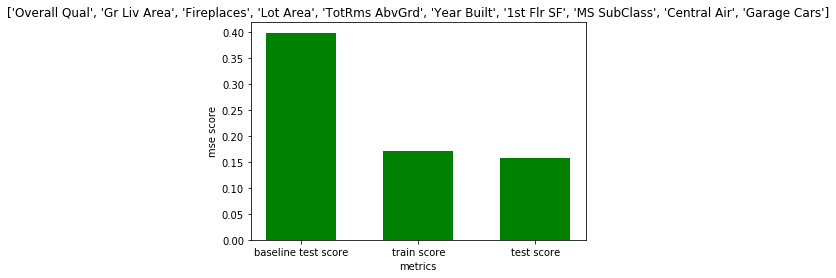

In [94]:
for col in cols_to_add:
    model_selector.run_combination('linear', None, 'mean', [col])
    # print(model_selector._find_optimal_train())
    print(model_selector.get_prediction_distribution())
    model_selector._plot_optimal_train()
    

In [95]:
model_selector._write_prediction('intermediate')

In [96]:
model_optimal_train_results['intermediate'] = model_selector._find_optimal_train()

Adjust with ridge regression grid search with ridge regression model
--

The solution found above will be adjust with ridge-grid

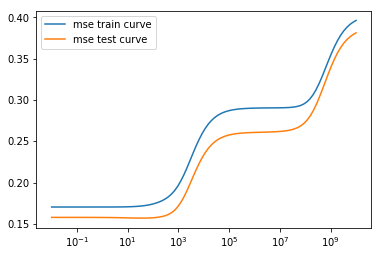

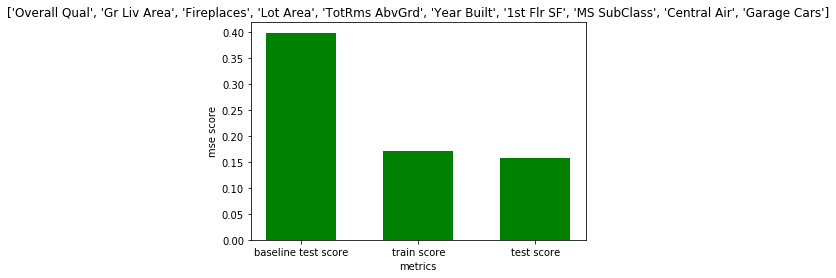

In [98]:
model_selector.reset_run()
cols = []
cols = optimal_cols.copy()
cols.extend(cols_to_add)

model_selector.run_ridge_grid('mean', cols)
model_selector._plot_optimal_train()
model_selector._write_prediction('intermediate')

In [101]:
model_selector._write_prediction('intermediate_adjusted')

In [102]:
model_optimal_train_results['intermediate_adjusted'] = model_selector._find_optimal_train()

C. Complex model build with all the (remaining) features 
--

In [105]:
sample_data._df_train_data.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Area', 'Street',
       'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope',
       'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Exter Qual', 'Exter Cond', 'Foundation',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Garage Cars',
       'Garage Area', 'Paved Drive', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val',
       'Mo Sold', 'Yr Sold', 'Sale Type', 'Sale Condition', 'SalePrice'],
      dt

In [115]:
alpha = 100
model_selector.reset_run()
model_selector.run_combinations('ridge', alpha, 'mean', 59, 2000)
model_optimal_train_results['complex'] = model_selector._find_optimal_train()

In [116]:
model_selector.get_prediction_distribution()

count       500.000000
mean      96657.366878
std       35159.105532
min       37182.066759
25%       73179.205223
50%       88198.416102
75%      109415.012619
max      365023.631532
Name: SalePrice, dtype: float64

We observe that the distribution is far from the train's one and that we can't retain this model

In [117]:
model_selector._write_prediction('complex')

In [118]:
model_optimal_train_results['complex'] = model_selector._find_optimal_train()

D. Plot models comparisons
--

In [119]:
def plot_model_result(mode_results):
    df = pd.DataFrame(model_optimal_train_results)
    df = df.transpose()

    # check that all models have been evaluated with the same metric
    if (df.metric.drop_duplicates().count() == 1):
        metric = df.metric.drop_duplicates()
        df = df[['test_baseline', 'train_score', 'test_score']]
    
        ax = df.plot.bar(width=0.8)
        ax.set_title("Comparison of the models (metric : " + metric.values[0] + str(")"))
        ax.set_xlabel("models")
        ax.set_ylabel("scores")

        ax.set_xticklabels(df.index, rotation=0)            
        plt.show()

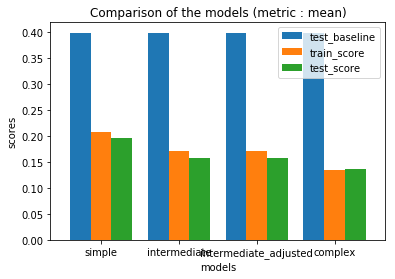

In [120]:
plot_model_result(model_optimal_train_results)

CONCLUSION
--
- intermediate model perform better than simple
- intermediate adjusted with ridge regression better a little better than the intermediate 
- complex model has a good performance in term of scores but the evaluated prediciton distribution is very bad.

REMARK 
--
the comparison was performed with a 'mean' metric.
To get a 'median' metric, just put the correct parameter in the machine and run it again.